In [ ]:
# Install PySpark
! pip install pyspark >& /dev/null

In [ ]:
from google.colab import drive
drive.mount("/drive", force_remount=True)

Mounted at /drive


In [ ]:
# importing all required packages at one place
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score ,classification_report ,confusion_matrix
from sklearn import tree
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, round

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDA_Project').getOrCreate()
sc = spark.sparkContext

In [ ]:
df = spark.read.csv("/drive/My Drive/BDA_Project/smoking_driking_dataset_Ver01.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- waistline: double (nullable = true)
 |-- sight_left: double (nullable = true)
 |-- sight_right: double (nullable = true)
 |-- hear_left: double (nullable = true)
 |-- hear_right: double (nullable = true)
 |-- SBP: double (nullable = true)
 |-- DBP: double (nullable = true)
 |-- BLDS: double (nullable = true)
 |-- tot_chole: double (nullable = true)
 |-- HDL_chole: double (nullable = true)
 |-- LDL_chole: double (nullable = true)
 |-- triglyceride: double (nullable = true)
 |-- hemoglobin: double (nullable = true)
 |-- urine_protein: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- SGOT_AST: double (nullable = true)
 |-- SGOT_ALT: double (nullable = true)
 |-- gamma_GTP: double (nullable = true)
 |-- SMK_stat_type_cd: double (nullable = true)
 |-- DRK_YN: string (nullable = true)



In [ ]:
df.show(5)

+----+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
| sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP| BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|
+----+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|Male| 35|   170|    75|     90.0|       1.0|        1.0|      1.0|       1.0|120.0|80.0| 99.0|    193.0|     48.0|    126.0|        92.0|      17.1|          1.0|             1.0|    21.0|    35.0|     40.0|             1.0|     Y|
|Male| 30|   180|    80|     89.0|       0.9|        1.2|      1.0| 

In [ ]:
dfp = df.toPandas()

In [ ]:
dfp.isna().sum()
# checking for null values in our data

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

In [ ]:
dfp.describe().transpose()
# general statistics of the data like average,

,count,mean,std,min,25%,50%,75%,max
age,991346.0,47.614491,14.181339,20.0,35.0,45.0,60.0,85.0
height,991346.0,162.240625,9.282957,130.0,155.0,160.0,170.0,190.0
weight,991346.0,63.284050,12.514241,25.0,55.0,60.0,70.0,140.0
waistline,991346.0,81.233358,11.850323,8.0,74.1,81.0,87.8,999.0
sight_left,991346.0,0.980834,0.605949,0.1,0.7,1.0,1.2,9.9
sight_right,991346.0,0.978429,0.604774,0.1,0.7,1.0,1.2,9.9
hear_left,991346.0,1.031495,0.174650,1.0,1.0,1.0,1.0,2.0
hear_right,991346.0,1.030476,0.171892,1.0,1.0,1.0,1.0,2.0
SBP,991346.0,122.432498,14.543148,67.0,112.0,120.0,131.0,273.0
DBP,991346.0,76.052627,9.889365,32.0,70.0,76.0,82.0,185.0


In [ ]:
df.count()

991346

In [ ]:
df = df.drop_duplicates()
# looking for duplicates

In [ ]:
df.count() #dropped duplicated rows

991320

<Axes: xlabel='age', ylabel='Count'>

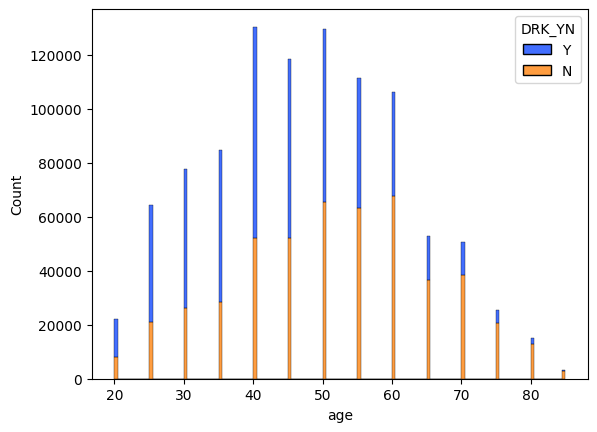

In [ ]:
# Exploratory Data Analytics
sns.histplot(data=dfp,x='age',palette='bright',hue='DRK_YN',multiple='stack')
# this graph shows us the drinking habits of people by age.

<Axes: xlabel='sex', ylabel='count'>

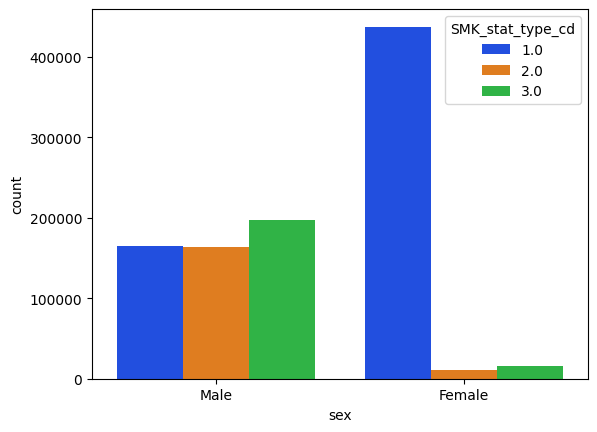

In [ ]:
sns.countplot(x='sex', hue='SMK_stat_type_cd', data=dfp, palette='bright')
# Gender wise bifurgation of smoking habits

<Axes: xlabel='age', ylabel='Count'>

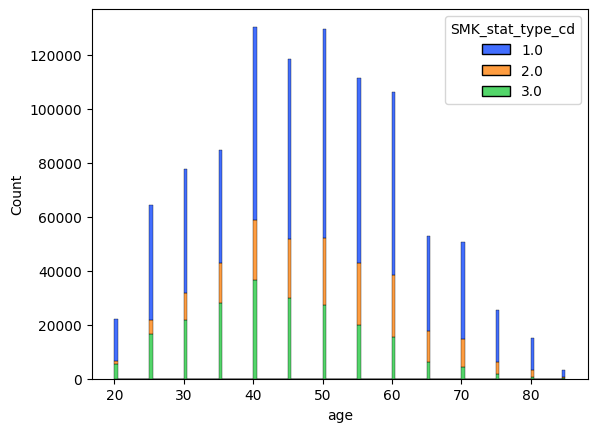

In [ ]:
sns.histplot(data=dfp,x='age',palette='bright',hue='SMK_stat_type_cd',multiple='stack')
# smoking habit of people as per age

<Axes: xlabel='weight', ylabel='Count'>

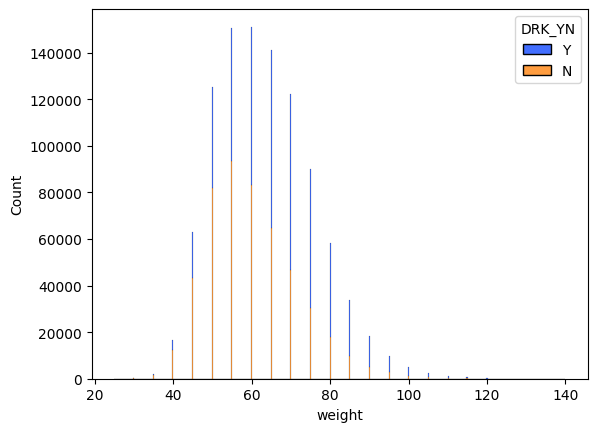

In [ ]:
sns.histplot(data=dfp,x='weight',palette='bright',hue='DRK_YN',multiple='stack')
# drinking habit of people distributed as per age.

In [ ]:
num_columns = [col for col in dfp.columns if dfp[col].dtype in ['int64', 'float64']]

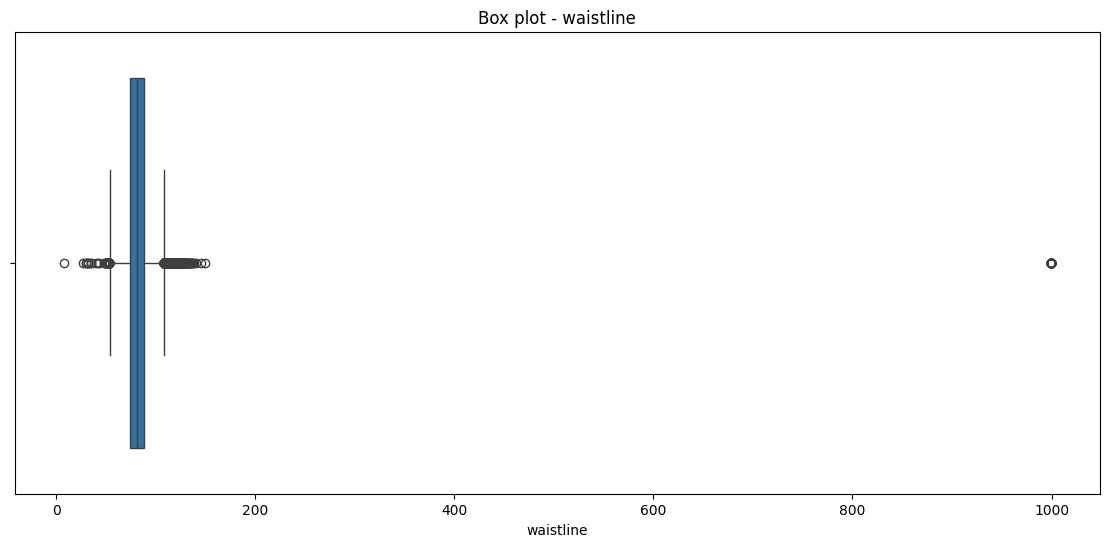

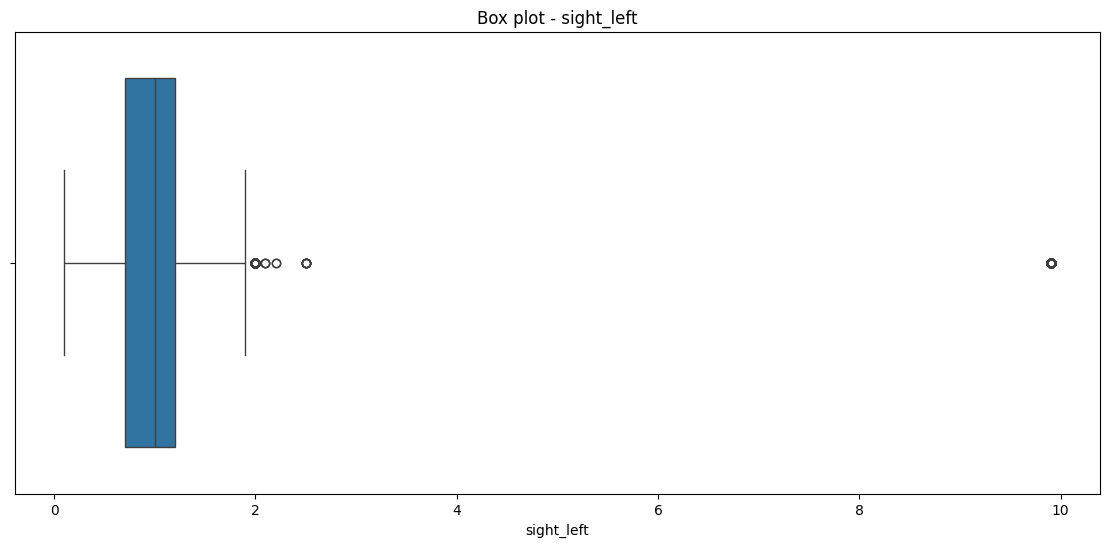

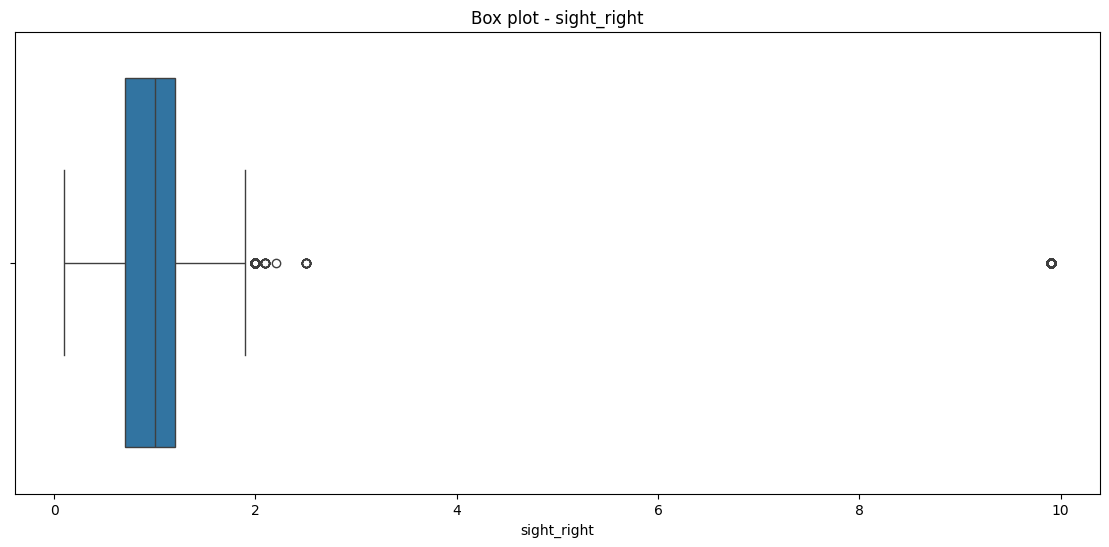

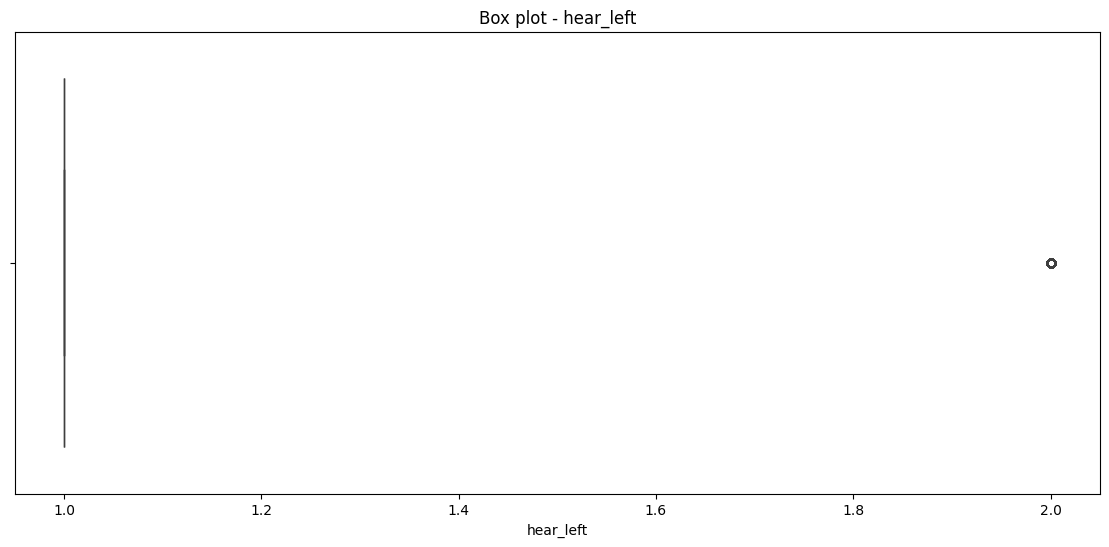

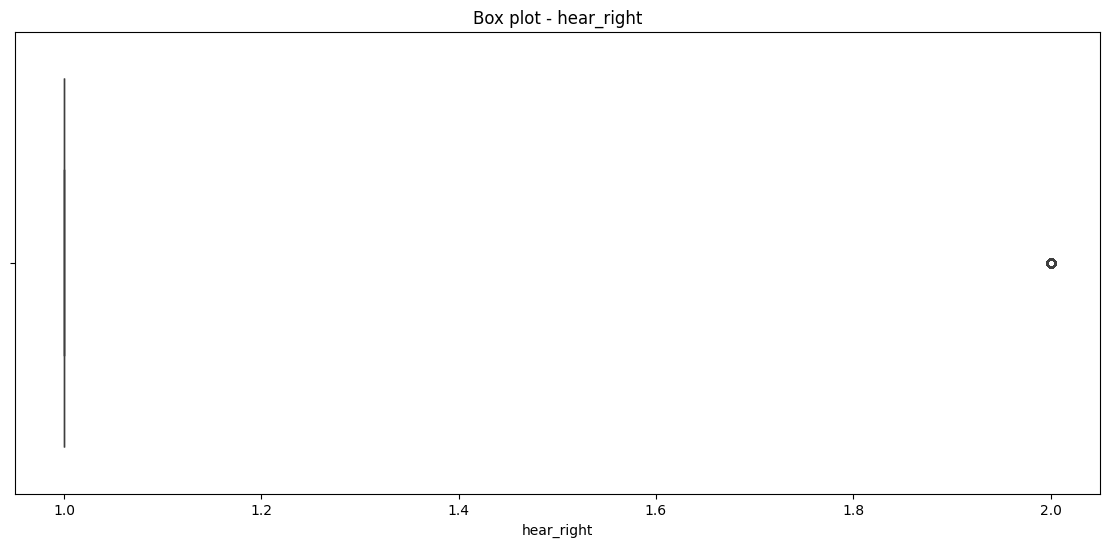

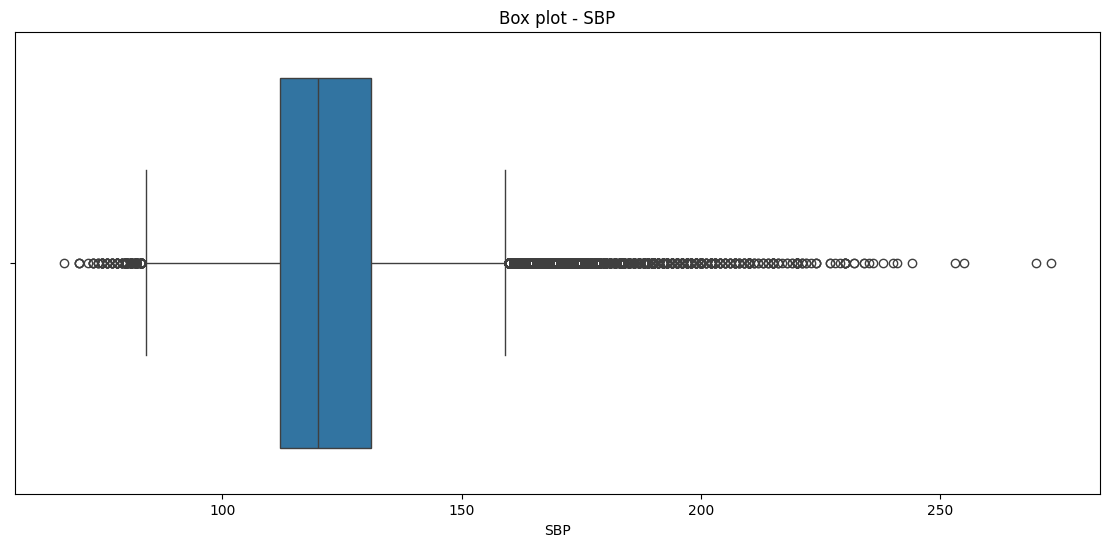

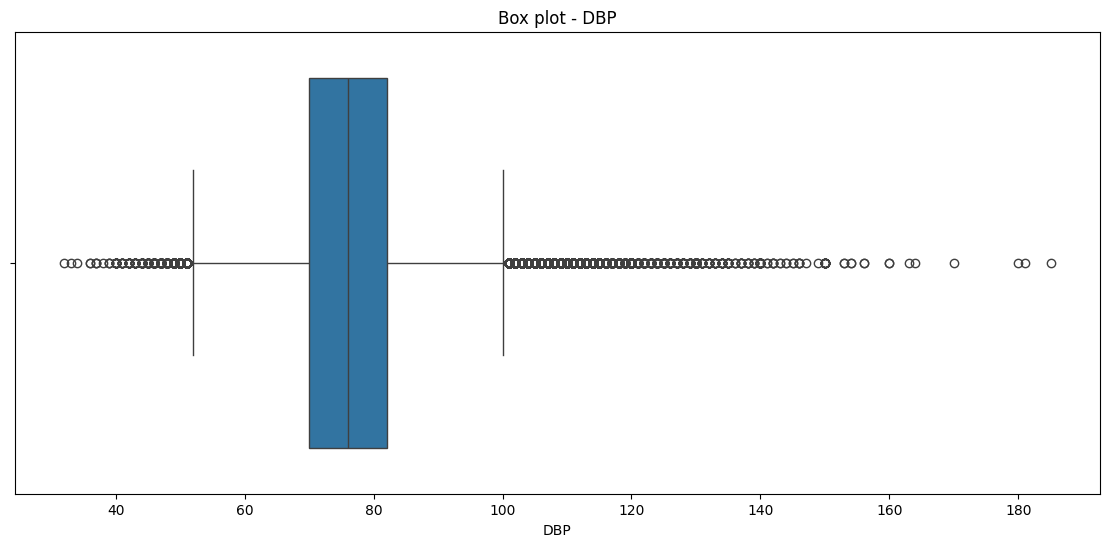

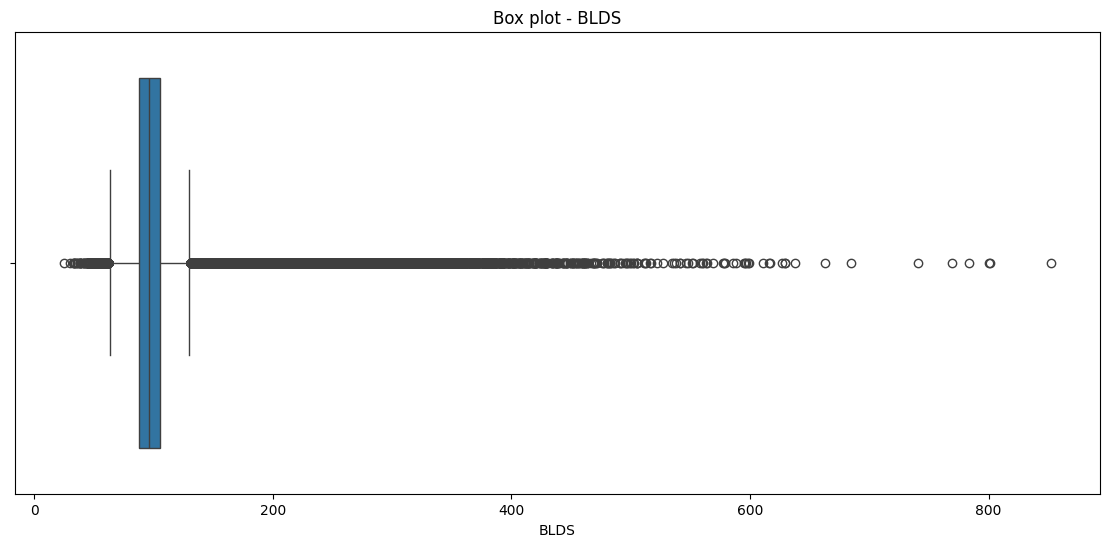

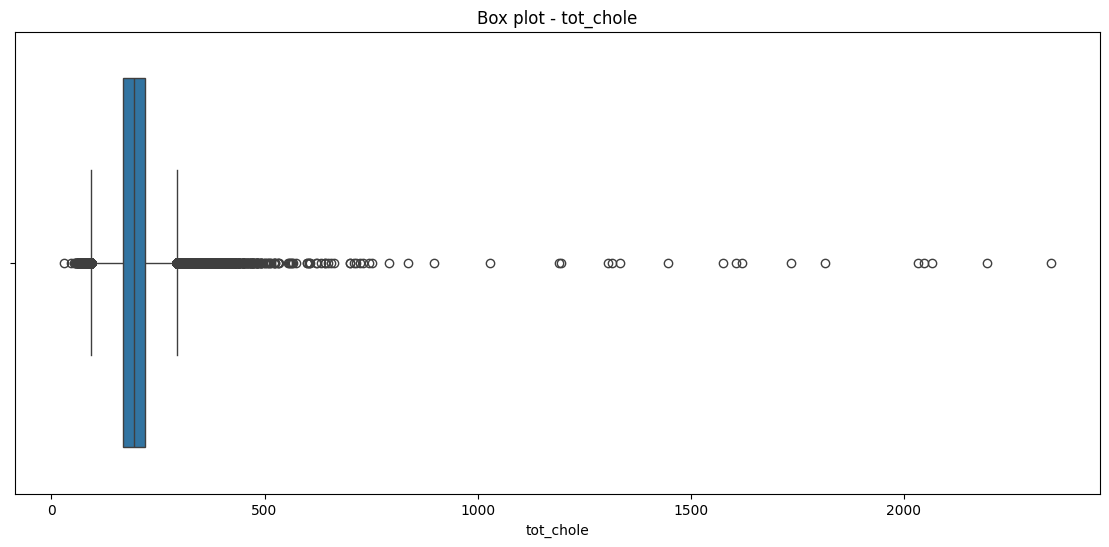

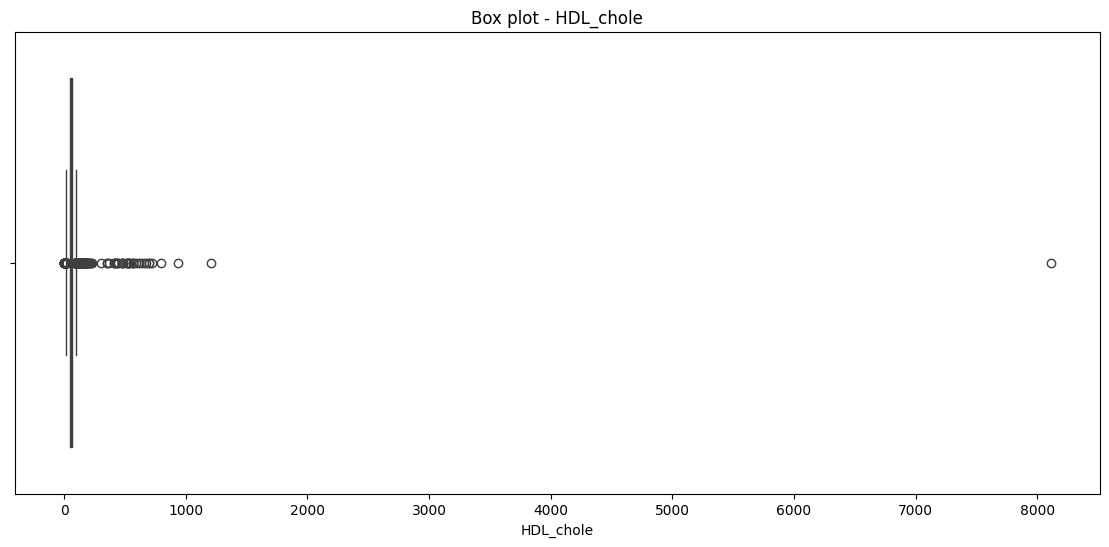

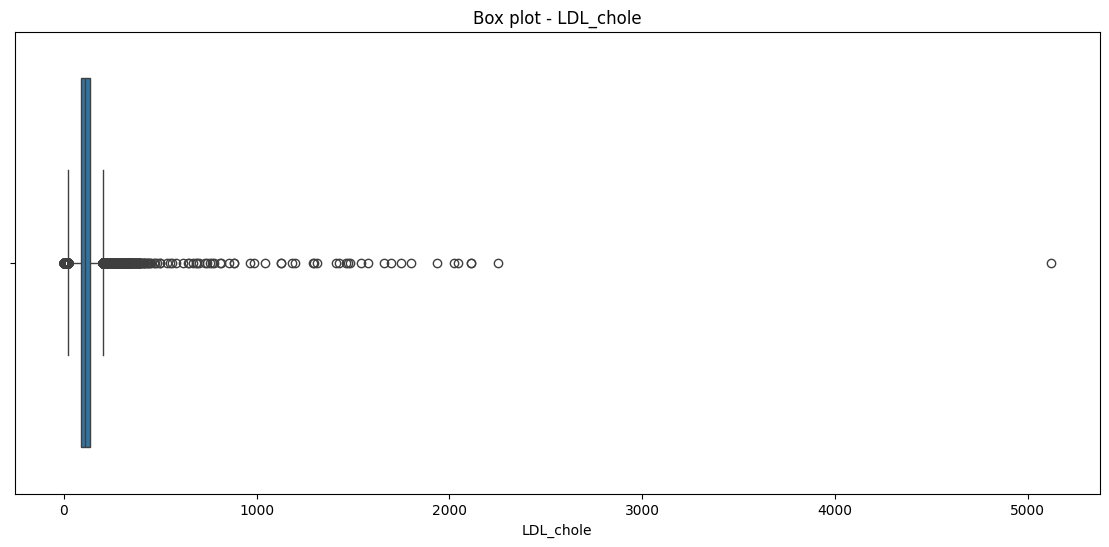

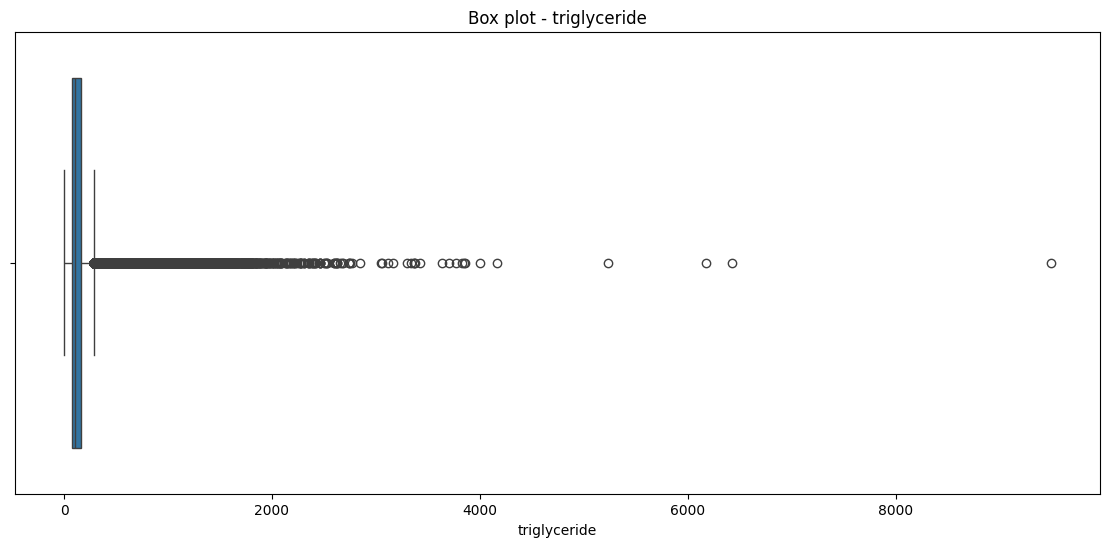

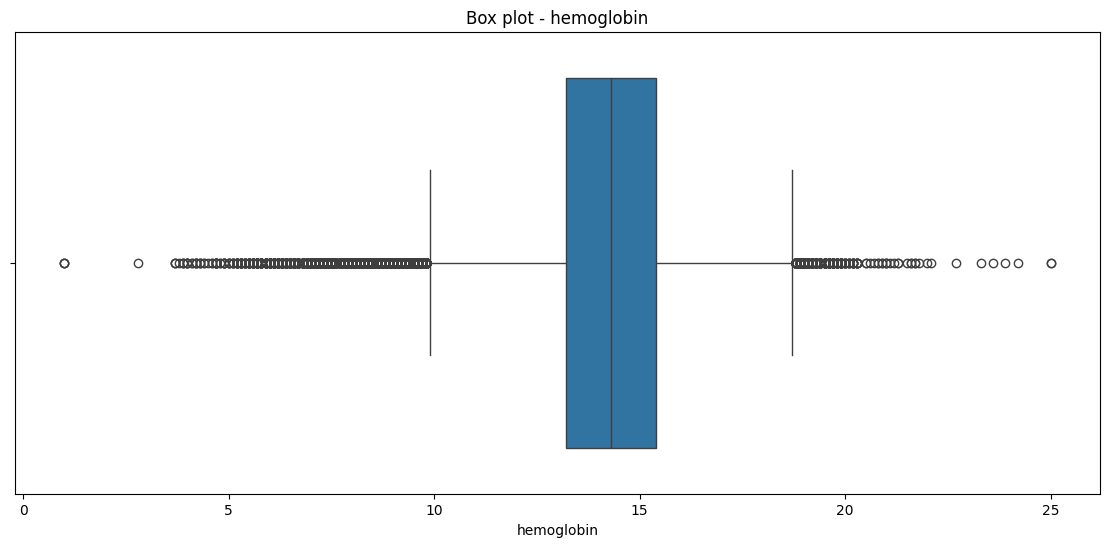

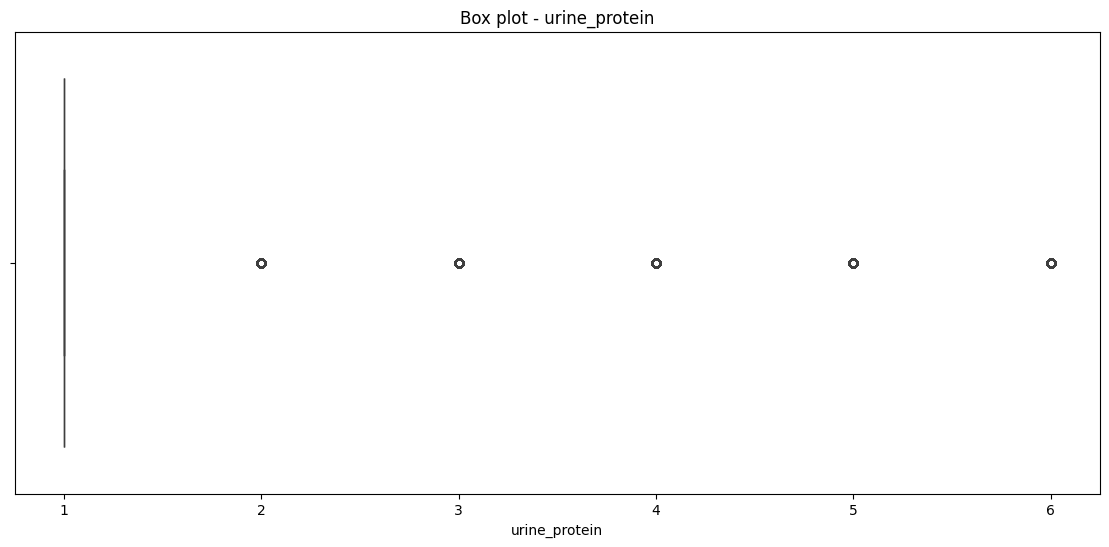

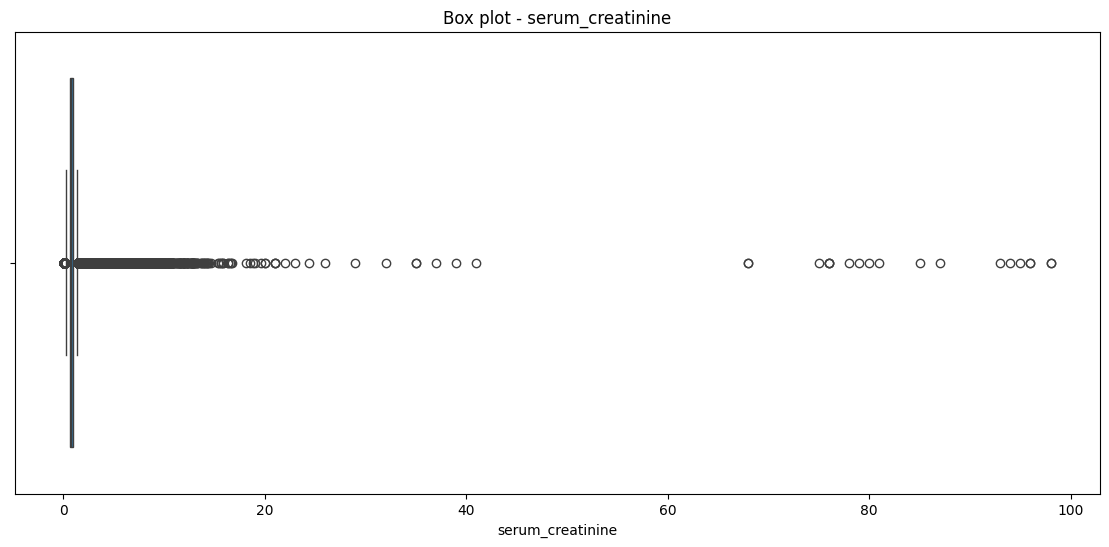

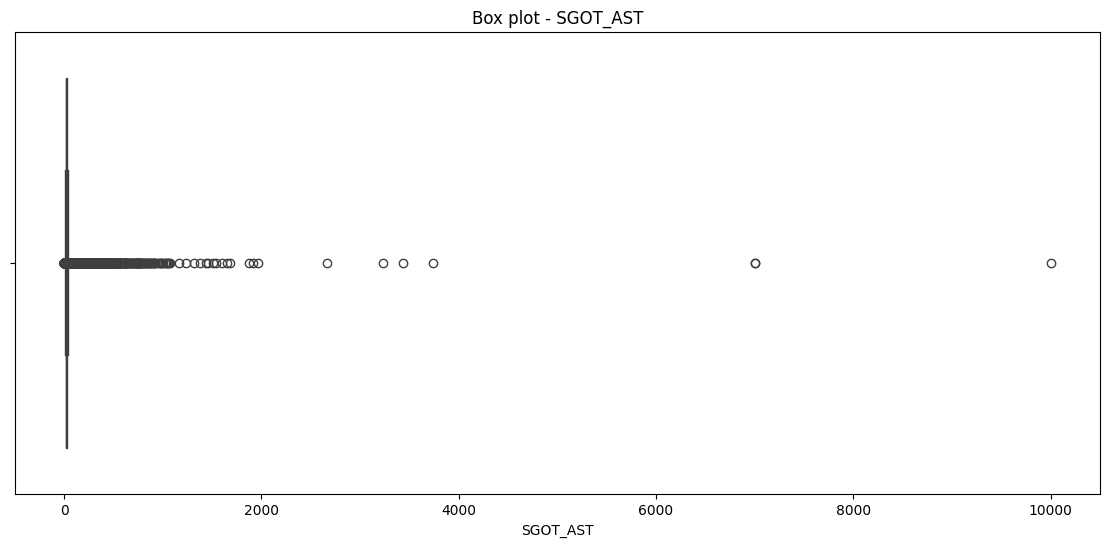

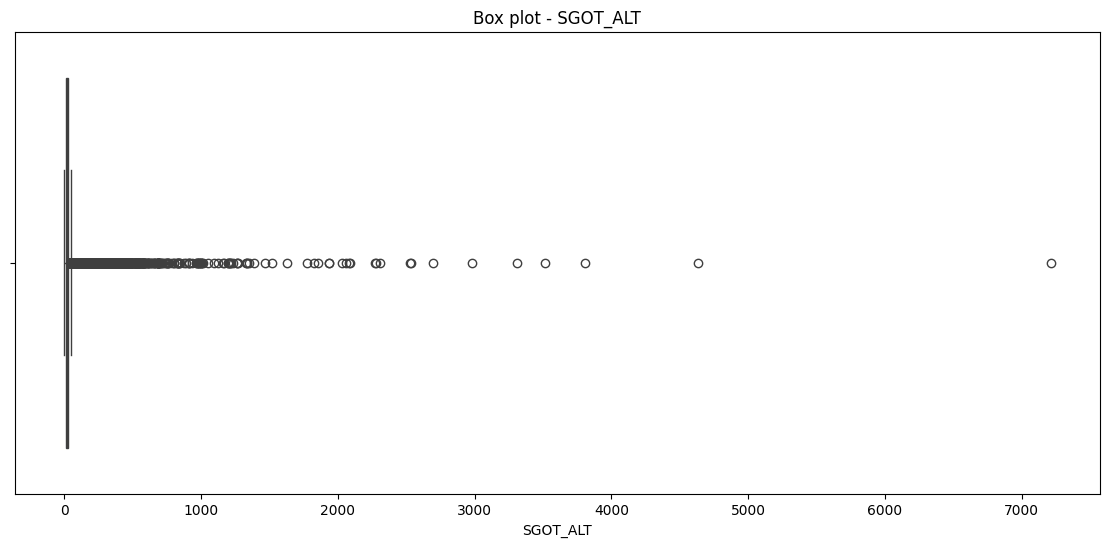

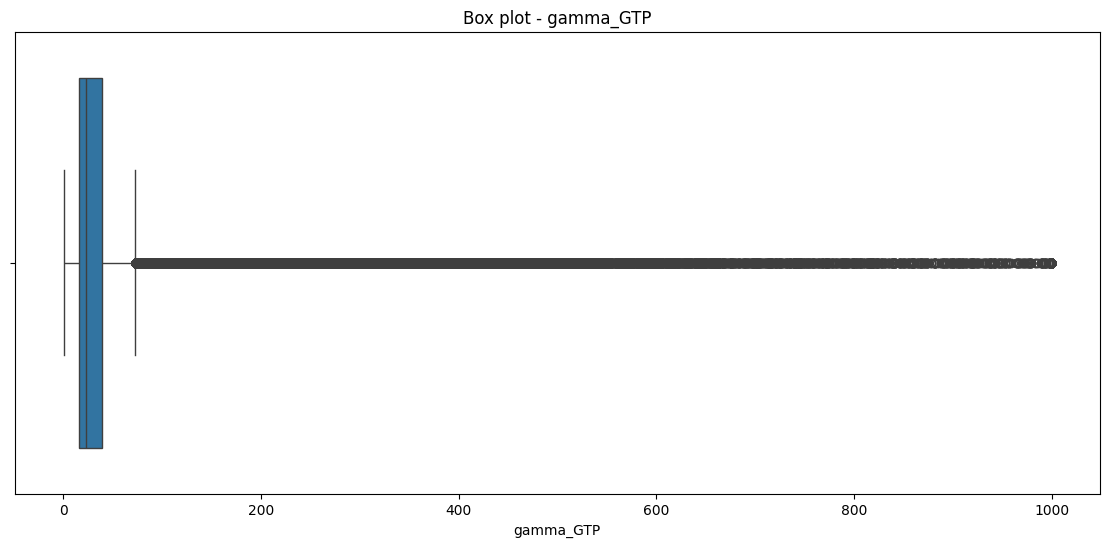

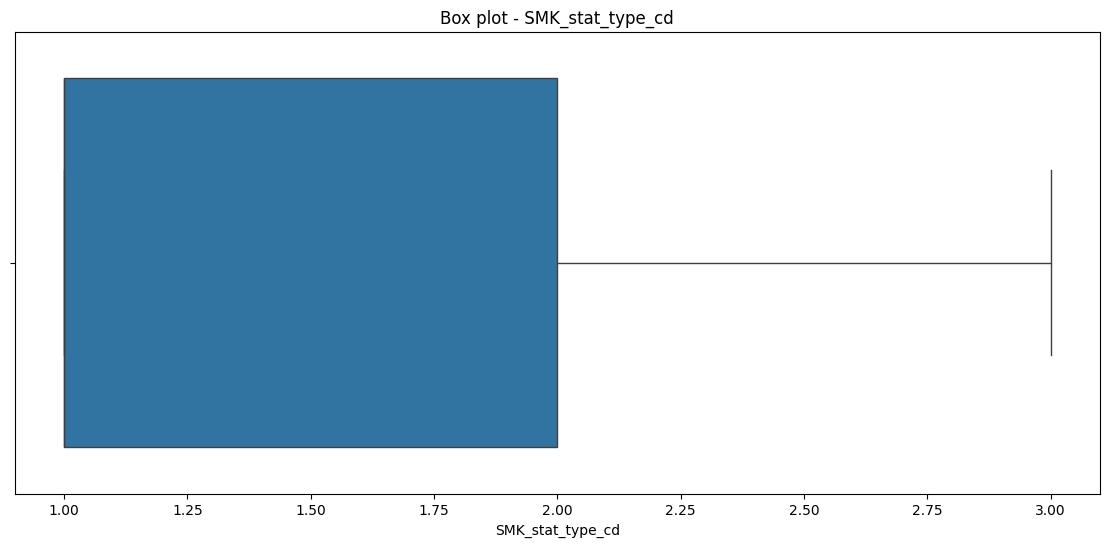

In [ ]:
# Creating box plots for each numerical column
for col in num_columns:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x= dfp[col])
    plt.title(f'Box plot - {col}')
    plt.show()


In [ ]:
num_columns = ['waistline',
'sight_right',
'sight_left',
 'SBP',
 'DBP',
 'BLDS',
 'tot_chole',
 'HDL_chole',
 'LDL_chole',
 'triglyceride',
 'hemoglobin',
 'serum_creatinine',
 'SGOT_AST',
 'SGOT_ALT',
 'gamma_GTP']

In [ ]:
# Remove outliers using z-score method
for column in num_columns:
    # Calculate z-scores
    mean_value = df.select(mean(column)).collect()[0][0]
    std_dev = df.select(stddev(column)).collect()[0][0]
    z_scores = (df[column] - mean_value) / std_dev

    threshold = 3
    # Filter out outliers based on z-score threshold
    outliers = df[abs(z_scores) > threshold]
    print(f"Number of outliers in {column}: {outliers.count()}")
    df = df.filter(abs(z_scores) <= threshold)


print("Data cleaning completed.")

Number of outliers in waistline: 638
Number of outliers in sight_right: 3108
Number of outliers in sight_left: 2633
Number of outliers in SBP: 6894
Number of outliers in DBP: 4498
Number of outliers in BLDS: 17877
Number of outliers in tot_chole: 4656
Number of outliers in HDL_chole: 6906
Number of outliers in LDL_chole: 2424
Number of outliers in triglyceride: 14860
Number of outliers in hemoglobin: 6575
Number of outliers in serum_creatinine: 1084
Number of outliers in SGOT_AST: 5078
Number of outliers in SGOT_ALT: 15917
Number of outliers in gamma_GTP: 15307
Data cleaning completed.


In [ ]:
dfp1 = df.toPandas()
dfp1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,882865.0,47.464839,14.262972,20.0,35.0,45.0,60.0,85.0
height,882865.0,162.068017,9.268359,130.0,155.0,160.0,170.0,190.0
weight,882865.0,62.691652,12.105340,25.0,55.0,60.0,70.0,135.0
waistline,882865.0,80.649154,9.373173,48.0,74.0,81.0,87.0,116.6
sight_left,882865.0,0.954747,0.341042,0.1,0.7,1.0,1.2,2.5
sight_right,882865.0,0.952210,0.339438,0.1,0.7,1.0,1.2,2.5
hear_left,882865.0,1.030906,0.173064,1.0,1.0,1.0,1.0,2.0
hear_right,882865.0,1.029830,0.170119,1.0,1.0,1.0,1.0,2.0
SBP,882865.0,121.478702,13.654597,79.0,111.0,120.0,130.0,165.0
DBP,882865.0,75.442729,9.307915,47.0,70.0,76.0,81.0,104.0


In [ ]:
# creating new column which will give us the BMI feature of people
# Perform division between two columns
df = df.withColumn('bmi', round(col('weight') / ((col('height')/100)**2), 2))

In [ ]:
# Defining the StringIndexer for our drk_yn column so that we can use it in our model as numerical value
indexer_DRK_YN = StringIndexer(inputCol="DRK_YN", outputCol="DRK_YN_indexed")

In [ ]:
#Pipeline
processing = Pipeline(stages = [
    indexer_DRK_YN
])

In [ ]:
df = processing.fit(df).transform(df) # Fitting indexer to the DataFrame and transform it
df.show()

+------+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+-----+--------------+
|   sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP| BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|  bmi|DRK_YN_indexed|
+------+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+-----+--------------+
|Female| 60|   160|    50|     74.0|       0.6|        0.9|      1.0|       1.0|132.0|81.0|103.0|    130.0|     59.0|     59.0|        56.0|      12.9|          1.0|             0.7|    29.0|    21.0|     11.0|             1.0|     

In [ ]:
train, test = df.randomSplit([0.75, 0.25], seed = 1) #slitting our data sdt into train and test data

In [ ]:
# vectorizing the numerical columns
vector = VectorAssembler(inputCols = ['age', 'bmi', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP'], outputCol='features')

In [ ]:
scaled = StandardScaler(inputCol='features', outputCol='scaled_features') # scaling the features

In [ ]:
lr = LogisticRegression(featuresCol='scaled_features', labelCol='SMK_stat_type_cd', maxIter=5) # performing the logisting regression for smoking prediction
# fitting the vector and scaled features into pipeline
lr_pipe_smoke = Pipeline(stages=[
    vector,
    scaled,
    lr
])
model_lr_smoke = lr_pipe_smoke.fit(train)

In [ ]:
predictions = model_lr_smoke.transform(test)
predictions.show(15)

+------+---+------+------+---------+----------+-----------+---------+----------+-----+----+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+-----+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|   sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP|BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|  bmi|DRK_YN_indexed|            features|     scaled_features|       rawPrediction|         probability|prediction|
+------+---+------+------+---------+----------+-----------+---------+----------+-----+----+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+-----+--------------+--------------------+--------------------+----

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol = 'SMK_stat_type_cd') # This evaluator focuses on comparing the predictions our model made against the actual answers.

In [ ]:
roc_auc_log_reg = evaluator.evaluate(predictions) #We ask our evaluator to check how well the model did on our test data.

In [ ]:
print(f' Logistic reggression model accuracy: {roc_auc_log_reg:.2f}')

 Logistic reggression model accuracy: 0.63


In [ ]:
predictions.select('prediction').distinct().show() #checking that our model actually predicted all classes.

+----------+
|prediction|
+----------+
|       1.0|
|       3.0|
|       2.0|
+----------+



In [ ]:
#we set up a pipeline to process our data. This pipeline has two steps:
# 1. Creating a feature vector from our data.
# 2. Scaling these features so they're easier for our model to use.
pipeline_transform = Pipeline(stages=[vector, scaled])
train_transform = pipeline_transform.fit(train).transform(train) # Now, we use our pipeline to transform our training data, getting it ready for the model.
test_transform = pipeline_transform.fit(test).transform(test) #We do the same transformation for our test data.

In [ ]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='SMK_stat_type_cd', maxDepth=5)
evaluator_cross = MulticlassClassificationEvaluator(labelCol='SMK_stat_type_cd', metricName='accuracy')

In [ ]:
# Create ParamGrid for Cross Validation
paramGrid_dt = (ParamGridBuilder()
               .addGrid(dt.maxDepth, [2, 5, 10])
               .addGrid(dt.maxBins, [20, 30, 40])
               .build())

In [ ]:
crossval_dt = CrossValidator(estimator=dt,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=evaluator_cross,
                             numFolds=3)

In [ ]:
# Fit the model
model_dt = crossval_dt.fit(train_transform)

In [ ]:
# Fetching best model
bestModel_dt = model_dt.bestModel
# Make predictions and evaluate
predictions_dt = bestModel_dt.transform(test_transform)

In [ ]:
# Evaluate the best model
accuracy_dt = evaluator_cross.evaluate(predictions_dt)
print(f'Best Decision Tree Model Accuracy: {accuracy_dt:.2f}')

Best Decision Tree Model Accuracy: 0.68


In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='SMK_stat_type_cd', numTrees=10)

In [ ]:
# Create ParamGrid for Cross Validation
paramGrid_rf = (ParamGridBuilder()
               .addGrid(rf.numTrees, [3,4])
               .addGrid(rf.maxDepth, [2,5])
               .build())

In [ ]:
# Set up 3-fold cross-validation
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_cross,
                             numFolds=2)
model_rf = crossval_rf.fit(train_transform)

In [ ]:
# Fetching best model
bestModel_rf = model_rf.bestModel

In [ ]:
# Make predictions and evaluate
predictions_rf = bestModel_rf.transform(test_transform)

In [ ]:
# Evaluate the best model
accuracy_rf = evaluator_cross.evaluate(predictions_rf)
print(f'Best Random Forest Model Accuracy: {accuracy_rf:.2f}')

Best Random Forest Model Accuracy: 0.66


In [ ]:
# Get feature importances
importances = bestModel_dt.featureImportances.toArray()

In [ ]:
 print(importances)

[7.21169815e-02 1.93898194e-02 1.50007908e-02 6.46010799e-04
 5.48412861e-04 0.00000000e+00 0.00000000e+00 8.58791775e-04
 4.92997424e-04 2.53334859e-04 3.50832940e-03 2.50738022e-03
 3.21194259e-03 3.50504167e-03 6.58501101e-01 2.17173276e-05
 1.18152858e-01 6.69298939e-03 2.47901833e-03 9.21124828e-02]


In [ ]:
# Convert feature importances to a list
feature_list = ['age', 'bmi', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
                'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']

In [ ]:
feature_importance_dict = dict(zip(feature_list, importances)) # Map feature importances to the feature names
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True) # Sorting the feature importances by most important first
sorted_features, sorted_importances = zip(*sorted_feature_importances) # Unzip the feature names and their importance scores

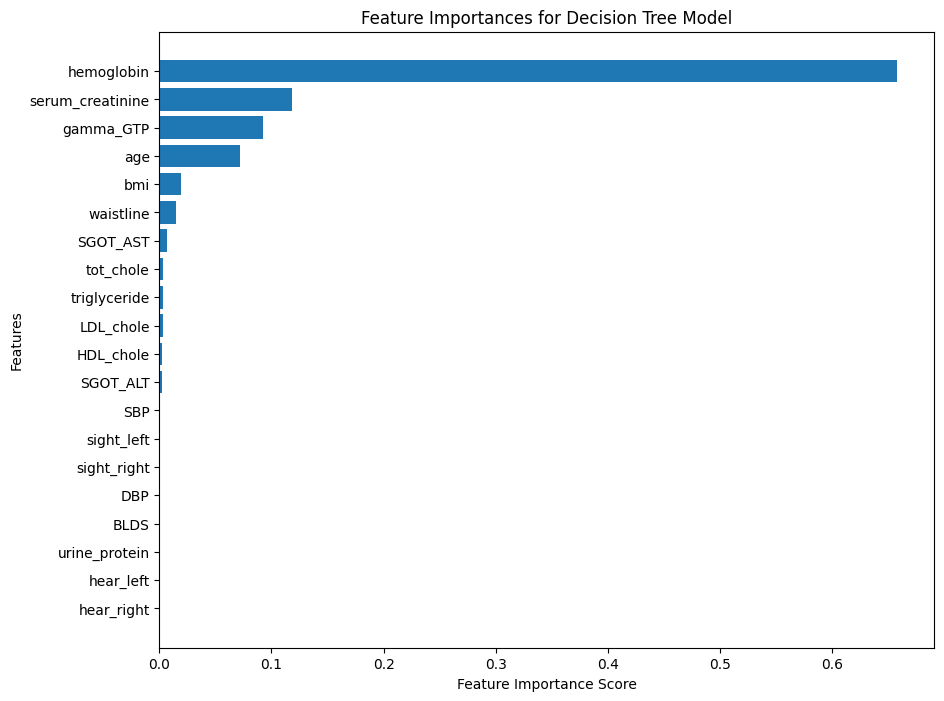

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances for Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#Logistic Regression for Drink_yn prediction
lr_drink = LogisticRegression(featuresCol='scaled_features', labelCol='DRK_YN_indexed', maxIter=5)

In [ ]:
lr_pipe_drink = Pipeline(stages=[
    vector,
    scaled,
    lr_drink
])
model_lr_drink = lr_pipe_drink.fit(train)

In [ ]:
predictions_drinks = model_lr_drink.transform(test)
predictions_drinks.show(15)

+------+---+------+------+---------+----------+-----------+---------+----------+-----+----+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+-----+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|   sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP|BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|  bmi|DRK_YN_indexed|            features|     scaled_features|       rawPrediction|         probability|prediction|
+------+---+------+------+---------+----------+-----------+---------+----------+-----+----+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+-----+--------------+--------------------+--------------------+----

In [ ]:
evaluator_drink = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol = 'DRK_YN_indexed') #comparing our predictions to actual answers
roc_auc_log_reg_drink = evaluator_drink.evaluate(predictions_drinks) #evaluating our model
print(f'Logistic Regresion Accuracy for Drink prediction: {roc_auc_log_reg_drink:.2f}')

Logistic Regresion Accuracy for Drink prediction: 0.70


In [ ]:
#decision tree for Drink_yn classification
# Decision Tree Classifier
dt_drink = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='DRK_YN_indexed', maxDepth=5)
evaluator_cross_drink = MulticlassClassificationEvaluator(labelCol='DRK_YN_indexed', metricName='accuracy')

In [ ]:
# Create ParamGrid for Cross Validation
paramGrid_dt_drink = (ParamGridBuilder()
               .addGrid(dt_drink.maxDepth, [2, 5])
               .addGrid(dt_drink.maxBins, [5, 10])
               .build())

In [ ]:
crossval_dt_drink = CrossValidator(estimator=dt_drink,
                             estimatorParamMaps=paramGrid_dt_drink,
                             evaluator=evaluator_cross_drink,
                             numFolds=3)

In [ ]:
model_dt_drink = crossval_dt_drink.fit(train_transform)

In [ ]:
# Fetching best model
bestModel_dt_drink = model_dt_drink.bestModel

In [ ]:
# Make predictions and evaluate
predictions_dt_drink = bestModel_dt_drink.transform(test_transform)

In [ ]:
# Evaluate the best model
accuracy_dt_drink = evaluator_cross_drink.evaluate(predictions_dt_drink)
print(f'Best Decision Tree Model Accuracy for Drink Prediction: {accuracy_dt_drink:.2f}')

Best Decision Tree Model Accuracy for Drink Prediction: 0.69


In [ ]:
# random forest classification for drink_yn prediction
rf_drink = RandomForestClassifier(featuresCol='scaled_features', labelCol='DRK_YN_indexed', numTrees=10)

In [ ]:
# Create ParamGrid for Cross Validation
paramGrid_rf_drink = (ParamGridBuilder()
               .addGrid(rf_drink.numTrees, [1, 5])
               .addGrid(rf_drink.maxDepth, [2, 5])
               .build())

In [ ]:
# Set up 3-fold cross-validation
crossval_rf_drink = CrossValidator(estimator=rf_drink,
                             estimatorParamMaps=paramGrid_rf_drink,
                             evaluator=evaluator_cross_drink,
                             numFolds=3)
model_rf_drink = crossval_rf_drink.fit(train_transform)

In [ ]:
# Fetching best model
bestModel_rf_drink = model_rf_drink.bestModel

In [ ]:
# Make predictions and evaluate
predictions_rf_drink = bestModel_rf_drink.transform(test_transform)

In [ ]:
# Evaluate the best model
accuracy_rf = evaluator_cross_drink.evaluate(predictions_rf_drink)
print(f'Best Random Forest Model Accuracy: {accuracy_rf:.2f}')

Best Random Forest Model Accuracy: 0.69


In [ ]:
# Initialize GBTClassifier
gbt_drink = GBTClassifier(featuresCol='scaled_features', labelCol='DRK_YN_indexed')

In [ ]:
# parameter grid for hyperparameter tuning
paramGrid_gbt_drink = ParamGridBuilder() \
    .addGrid(gbt_drink.maxDepth, [2, 15]) \
    .addGrid(gbt_drink.maxBins, [5, 10]) \
    .addGrid(gbt_drink.maxIter, [3, 5]) \
    .build()

In [ ]:
crossval_gbt_drink = CrossValidator(estimator=gbt_drink,
                          estimatorParamMaps=paramGrid_gbt_drink,
                          evaluator=evaluator_cross_drink,
                          numFolds=5)


In [ ]:
# hoose the best set of parameters
model_gbt_drink = crossval_gbt_drink.fit(train_transform)

In [ ]:
# Fetching best model
bestModel_gbt_drink = model_gbt_drink.bestModel

In [ ]:
# Make predictions on the test data
predictions_gbt_drink = bestModel_gbt_drink.transform(test_transform)

In [ ]:
# Evaluate the best model
accuracy_gbt = evaluator_cross_drink.evaluate(predictions_gbt_drink)
print(f'Best Gradient Boosting Tree Model Accuracy: {accuracy_gbt:.2f}')

In [ ]:
#SVM Classifier for drinking_yn prediction
svm_drink = LinearSVC(featuresCol='scaled_features', labelCol='DRK_YN_indexed')
paramGrid_svm_drink = ParamGridBuilder() \
    .addGrid(svm_drink.maxIter, [10, 100]) \
    .addGrid(svm_drink.regParam, [0.01, 0.1]) \
    .build()

In [ ]:
evaluator_svm_drink = BinaryClassificationEvaluator(labelCol='DRK_YN_indexed')
crossval_svm_drink = CrossValidator(estimator=svm_drink,
                                    estimatorParamMaps=paramGrid_svm_drink,
                                    evaluator=evaluator_svm_drink,
                                    numFolds=5)

In [ ]:
model_svm_drink = crossval_svm_drink.fit(train_transform)
predictions_svm_drink = model_svm_drink.transform(test_transform)
accuracy_svm_drink = evaluator_svm_drink.evaluate(predictions_svm_drink)
print(f'SVM Model Accuracy for Drinking Prediction: {accuracy_svm_drink:.2f}')

In [ ]:
# Fetching best model
bestModel_svm_drink = model_svm_drink.bestModel

In [ ]:
# Make predictions on the test data
predictions_svm_drink = bestModel_gbt_drink.transform(test_transform)

In [ ]:
# Evaluate the best model
accuracy_svm = evaluator_cross_drink.evaluate(predictions_svm_drink)
print(f'Best Support Vector Machine Model Accuracy: {accuracy_svm:.2f}')